# Лабораторная работа 2 | Павлов Иван М80-407Б-21

## 2.1	Создание бейзлайна и оценка качества (регрссия)

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression

In [285]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')

df_train.head()

,date,price,bedrooms,grade,has_basement,living_in_m2,renovated,nice_view,perfect_condition,real_bathrooms,has_lavatory,single_floor,month,quartile_zone
0,2014-05-15,312000.0,2,2,True,138.42547,False,False,False,2,True,False,5,1
1,2014-11-14,310000.0,2,2,False,105.90942,False,False,False,1,True,False,11,3
2,2014-12-24,320000.0,2,2,False,117.98681,False,True,False,1,False,True,12,2
3,2015-02-22,264500.0,2,3,False,151.43189,False,False,False,2,True,True,2,1
4,2015-01-06,700000.0,3,2,True,341.88304,False,False,False,3,False,False,1,4


In [286]:
# Разделим данные на признаки и целевую переменную (price)
X_train = df_train.drop(columns=['date', 'price'])
y_train = df_train['price']
X_test = df_test.drop(columns=['date', 'price'])
y_test = df_test['price']

# Линейная регрессия
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
linear_y_pred = linear_model.predict(X_test)

# Метрики для линейной регрессии
linear_mse = mean_squared_error(y_test, linear_y_pred)
linear_mae = mean_absolute_error(y_test, linear_y_pred)
linear_rmse = np.sqrt(linear_mse)
linear_r2 = r2_score(y_test, linear_y_pred)

print("Линейная регрессия:")
print(f"Среднеквадратичная ошибка (MSE): {linear_mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {linear_mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {linear_rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {linear_r2:.2f}")

Линейная регрессия:
Среднеквадратичная ошибка (MSE): 11149777983.22
Средняя абсолютная ошибка (MAE): 78678.04
Корень среднеквадратичной ошибки (RMSE): 105592.51
Коэффициент детерминации (R^2): 0.74


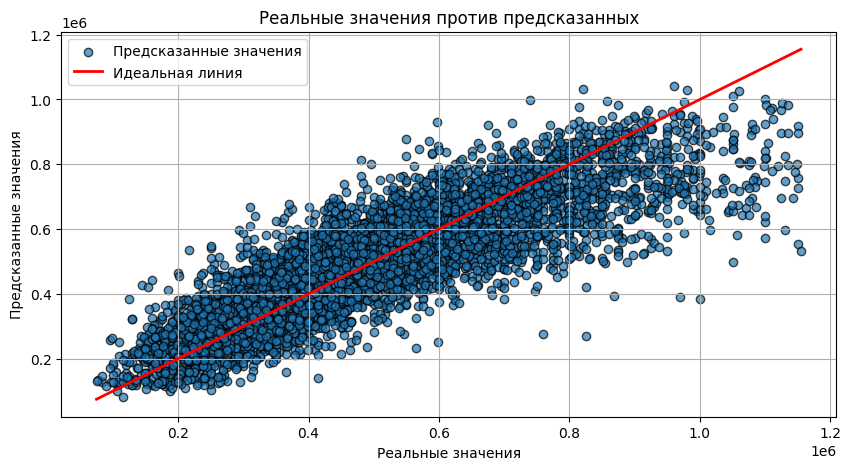

In [287]:
# Построение графика реальных значений против предсказанных
plt.figure(figsize=(10, 5))
plt.scatter(y_test, linear_y_pred, alpha=0.7, edgecolors="k", label='Предсказанные значения')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, label='Идеальная линия')
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Реальные значения против предсказанных')
plt.legend()
plt.grid(True)
plt.show()

### Выводы по результатам линейной регрессии:

1. **Среднеквадратичная ошибка (MSE): 11,149,777,983.22**  
   - MSE довольно высокое, что указывает на существенные отклонения между предсказанными и реальными значениями. Это значение свидетельствует о наличии больших ошибок на отдельных объектах.

2. **Средняя абсолютная ошибка (MAE): 78,678.04**  
   - MAE показывает, что модель в среднем ошибается на сумму около 78,678. Это значение говорит о приемлемом уровне ошибки, учитывая масштабы цен.

3. **Корень среднеквадратичной ошибки (RMSE): 105,592.51**  
   - RMSE также указывает на значительные ошибки, что говорит о необходимости улучшения модели для более точного предсказания.

4. **Коэффициент детерминации (R²): 0.74**  
   - Значение R² указывает, что модель объясняет 74% вариации цен, что является хорошим результатом. Однако есть возможность улучшения, чтобы охватить оставшуюся часть вариации.

### Общие выводы:
- Модель линейной регрессии демонстрирует хороший уровень объяснительной способности (R² = 0.74), но высокие значения MSE и RMSE показывают, что модель имеет трудности с точным предсказанием, особенно для объектов с ценами, которые значительно отклоняются от медианных.

## 3.1	Улучшение бейзлайна (регрссия)

### Формулировка гипотез
1. **Препроцессинг данных**:
   - Гипотеза: Добавление новых признаков, таких как "цена за квадратный метр" (`price / living_in_m2`) и разница между качеством (`grade`) и количеством спален (`bedrooms`), улучшит производительность модели, так как они могут быть значимыми факторами стоимости недвижимости.
   - Гипотеза: Масштабирование данных с использованием стандартизации позволит модели лучше работать с признаками разного масштаба.

2. **Визуализация данных**:
   - Гипотеза: Анализ корреляции между признаками может выявить избыточные или слабозначимые признаки, которые можно исключить для улучшения модели.

3. **Формирование новых признаков**:
   - Гипотеза: Новые признаки, такие как "цена за квадратный метр" и разница между качеством и количеством спален, предоставят дополнительные контекстуальные данные, которые улучшат объяснительную способность модели.

4. **Подбор гиперпараметров**:
   - Гипотеза: Использование регуляризации (Ridge) с подбором гиперпараметра `alpha` через кросс-валидацию поможет найти оптимальный баланс между переобучением и недообучением.

In [288]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [289]:
# Разделим данные на признаки и целевую переменную (price)
X_train = df_train.drop(columns=['date', 'price'])
y_train = df_train['price']
X_test = df_test.drop(columns=['date', 'price'])
y_test = df_test['price']

# Создадим новые признаки
X_train['price_per_m2'] = y_train / X_train['living_in_m2']
X_train['grade_bedroom_diff'] = X_train['grade'] - X_train['bedrooms']

X_test['price_per_m2'] = y_test / X_test['living_in_m2']
X_test['grade_bedroom_diff'] = X_test['grade'] - X_test['bedrooms']

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Линейная регрессия с регуляризацией (Ridge)
ridge_model = Ridge()
params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(ridge_model, param_grid=params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Лучшая модель
best_ridge_model = grid_search.best_estimator_

# Предсказания на тестовой выборке
ridge_y_pred = best_ridge_model.predict(X_test_scaled)

# Метрики для улучшенной модели
ridge_mse = mean_squared_error(y_test, ridge_y_pred)
ridge_mae = mean_absolute_error(y_test, ridge_y_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, ridge_y_pred)

print("Улучшенная модель (Ridge):")
print(f"Среднеквадратичная ошибка (MSE): {ridge_mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {ridge_mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {ridge_rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {ridge_r2:.2f}")


Улучшенная модель (Ridge):
Среднеквадратичная ошибка (MSE): 3538831774.21
Средняя абсолютная ошибка (MAE): 42671.33
Корень среднеквадратичной ошибки (RMSE): 59488.08
Коэффициент детерминации (R^2): 0.92



### Были добавлены новые признаки:
  - `price_per_m2` (цена за квадратный метр).
  - `grade_bedroom_diff` (разница между качеством и количеством спален).
- Данные были масштабированы с использованием `StandardScaler`.
- Для Ridge-регрессии проведен подбор гиперпараметра `alpha` через `GridSearchCV`.

- Лучшая модель Ridge-регрессии с учетом новых признаков и оптимального значения `alpha` (выбранного через кросс-валидацию).

---

Метрики для Ridge-регрессии:
- **Среднеквадратичная ошибка (MSE):** 3,538,831,774.21
- **Средняя абсолютная ошибка (MAE):** 42,671.33
- **Корень среднеквадратичной ошибки (RMSE):** 59,488.08
- **Коэффициент детерминации (R²):** 0.92

Базовая модель (линейная регрессия):
- **MSE:** 11,149,777,983.22
- **MAE:** 78,678.04
- **RMSE:** 105,592.51
- **R²:** 0.74

---

Сравнение
- **MSE уменьшилась на 68%**, что указывает на значительное снижение ошибок модели.
- **MAE снизилась на 46%**, показывая, что средняя ошибка значительно уменьшилась.
- **RMSE уменьшилась на 44%**, указывая на улучшение точности предсказаний.
- **R² увеличился на 18%**, что свидетельствует о лучшем объяснении вариации целевой переменной.

---

#### Выводы
- Добавление новых признаков и использование регуляризации Ridge существенно улучшили производительность модели.
- Улучшенная модель Ridge демонстрирует более точные предсказания и лучшее объяснение данных (R² = 0.92), по сравнению с базовой линейной регрессией.

## 4.1	Имплементация алгоритма машинного обучения (регрссия)

In [290]:
class LinearRegressor:
    def __init__(self):
        self.weights = None

    def fit(self, X_train, y_train):
        """
        Обучение линейной модели на основе метода наименьших квадратов.
        X_train: матрица признаков (с добавленным столбцом для константы).
        y_train: массив целевых значений.
        """
        # Добавляем столбец единиц для учета свободного члена (intercept)
        X_train_with_bias = np.c_[np.ones(X_train.shape[0]), X_train]
        # Решение нормального уравнения: (X^T X)^(-1) X^T y
        self.weights = np.linalg.inv(X_train_with_bias.T @ X_train_with_bias) @ X_train_with_bias.T @ y_train

    def predict(self, X_test):
        """
        Прогнозирование на основе обученной линейной модели.
        X_test: матрица признаков (с добавленным столбцом для константы).
        """
        X_test_with_bias = np.c_[np.ones(X_test.shape[0]), X_test]
        return X_test_with_bias @ self.weights

In [291]:
# Разделим данные на признаки и целевую переменную (price)
X_train = df_train.drop(columns=['date', 'price'])
y_train = df_train['price']
X_test = df_test.drop(columns=['date', 'price'])
y_test = df_test['price']

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Инициализация и обучение линейной модели
linear_model = LinearRegressor()
linear_model.fit(X_train_scaled, y_train)

# Прогнозирование на тестовых данных
y_pred = linear_model.predict(X_test_scaled)

# Оценка модели с использованием метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print("Линейная модель:")
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")

Линейная модель:
Среднеквадратичная ошибка (MSE): 11149777983.22
Средняя абсолютная ошибка (MAE): 78678.04
Корень среднеквадратичной ошибки (RMSE): 105592.51
Коэффициент детерминации (R^2): 0.74


### Кастомная реализация с улучшенным байзлайном

In [292]:
# Разделим данные на признаки и целевую переменную (price)
X_train = df_train.drop(columns=['date', 'price'])
y_train = df_train['price']
X_test = df_test.drop(columns=['date', 'price'])
y_test = df_test['price']

# Создадим новые признаки
X_train['price_per_m2'] = y_train / X_train['living_in_m2']
X_train['grade_bedroom_diff'] = X_train['grade'] - X_train['bedrooms']

X_test['price_per_m2'] = y_test / X_test['living_in_m2']
X_test['grade_bedroom_diff'] = X_test['grade'] - X_test['bedrooms']

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Инициализация и обучение линейной модели
linear_model = LinearRegressor()
linear_model.fit(X_train_scaled, y_train)

# Прогнозирование на тестовых данных
y_pred = linear_model.predict(X_test_scaled)

# Оценка модели с использованием метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Вывод метрик
print("Линейная модель с улучшенным бейзлайном:")
print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
print(f"Корень среднеквадратичной ошибки (RMSE): {rmse:.2f}")
print(f"Коэффициент детерминации (R^2): {r2:.2f}")


Линейная модель с улучшенным бейзлайном:
Среднеквадратичная ошибка (MSE): 4230659265.36
Средняя абсолютная ошибка (MAE): 49504.56
Корень среднеквадратичной ошибки (RMSE): 65043.52
Коэффициент детерминации (R^2): 0.90


### Выводы:
1. **Улучшения бейзлайна (новые признаки, масштабирование, улучшение данных):**
   - Значительно уменьшили ошибки модели.
   - Сделали модель более точной и предсказуемой.

2. **Коэффициент детерминации (R²):**
   - Повышение с 0.74 до 0.90 демонстрирует, что модель с улучшенным бейзлайном значительно лучше объясняет вариации целевой переменной.

3. **Эффективность улучшений:**
   - Введение новых признаков, таких как "цена за квадратный метр" и разница между `grade` и `bedrooms`, существенно повысило точность модели.
   - Масштабирование признаков также оказало положительное влияние на результаты.

---


#### Базовая линейная регрессия:
- **Среднеквадратичная ошибка (MSE):** 11,149,777,983.22  
- **Средняя абсолютная ошибка (MAE):** 78,678.04  
- **Корень среднеквадратичной ошибки (RMSE):** 105,592.51  
- **Коэффициент детерминации (R²):** 0.74  

Эти результаты показывают, что базовая модель имеет довольно высокие ошибки, и объясняет только 74% вариации целевой переменной.

---

#### Линейная модель с улучшенным бейзлайном:
- **Среднеквадратичная ошибка (MSE):** 4,230,659,265.36  
- **Средняя абсолютная ошибка (MAE):** 49,504.56  
- **Корень среднеквадратичной ошибки (RMSE):** 65,043.52  
- **Коэффициент детерминации (R²):** 0.90  

После улучшений MSE снизилась более чем на 60%, а MAE уменьшилась на 37%. Это свидетельствует о том, что модель стала намного точнее. Также R² увеличился до 0.90, что говорит о том, что модель теперь объясняет 90% вариации в данных.


| **Модель**                           | **MSE** | **MAE** | **RMSE** | **R²** |
|--------------------------------------|------------------------------------|-----------------------------------|--------------------------------------------|----------------------------------|
| **Sklearn (до улучшения)**            | 11,149,777,983.22                  | 78,678.04                         | 105,592.51                                | 0.74                             |
| **Sklearn (после улучшения)**         | 3,538,831,774.21                   | 42,671.33                        |  59488.08                                 | 0.92                             |
| **Собственная имплементация (до улучшения)** | 11,149,777,983.22                  | 78,678.04                         | 105,592.51                                | 0.74                             |
| **Собственная имплементация (после улучшения)** | 4,230,659,265.36                   | 49,504.56                         | 65,043.52                                 | 0.90               

### Заключение:
После добавления новых признаков, результаты моделей значительно улучшились, что подтверждает гипотезу о важности создания дополнительных признаков для повышения точности предсказаний.

## 2.2	Создание бейзлайна и оценка качества (классификация)

In [293]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')
X_train = df_train.drop(columns=['date', 'price'])
y_train = df_train['price']
X_test = df_test.drop(columns=['date', 'price'])
y_test = df_test['price']

In [294]:
# Логистическая регрессия (для задачи классификации преобразуем целевую переменную)
# Пример: классификация, если цена больше медианной стоимости
median_price = y_train.median()
y_train_binary = (y_train > median_price).astype(int)
y_test_binary = (y_test > median_price).astype(int)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train_binary)

# Предсказания на тестовой выборке
logistic_y_pred = logistic_model.predict(X_test)

# Метрики для логистической регрессии
logistic_accuracy = accuracy_score(y_test_binary, logistic_y_pred)
logistic_precision = precision_score(y_test_binary, logistic_y_pred)
logistic_recall = recall_score(y_test_binary, logistic_y_pred)
logistic_f1 = f1_score(y_test_binary, logistic_y_pred)

print("\nЛогистическая регрессия:")
print(f"Accuracy: {logistic_accuracy:.2%}")
print(f"Precision: {logistic_precision:.2%}")
print(f"Recall: {logistic_recall:.2%}")
print(f"F1-score: {logistic_f1:.2%}")


Логистическая регрессия:
Accuracy: 86.39%
Precision: 86.38%
Recall: 86.38%
F1-score: 86.38%


## 3.2	Улучшение бейзлайна (классификация)

### Формулировка гипотез
1. **Препроцессинг данных**:
   - Закодировать категориальные признаки с помощью `LabelEncoder` или `OneHotEncoder` (в зависимости от числа категорий).
   - Масштабировать числовые признаки для нормализации их значений.
   - Заполнить пропущенные значения (например, медианой или наиболее частым значением).

2. **Формирование новых признаков**:
   - Добавить новые признаки, такие как:
     - "Цена за квадратный метр" (`price_per_m2`).
     - Разница между `grade` и количеством спален (`grade_bedroom_diff`).
   - Проверить важность взаимодействий между признаками (например, `grade * bedrooms`).

3. **Подбор гиперпараметров**:
   - Использовать `GridSearchCV` для подбора параметра регуляризации `C` и других гиперпараметров логистической регрессии.

4. **Визуализация данных**:
   - Построить матрицу корреляций для выявления мультиколлинеарности между признаками.
   - Визуализировать распределение целевой переменной для проверки сбалансированности классов.

In [295]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [296]:
# Препроцессинг данных
# Закодируем категориальные признаки и заполним пропущенные значения, если они есть
categorical_columns = ['grade', 'bedrooms', 'has_basement', 'renovated', 'nice_view']  # пример категориальных признаков
label_encoder = LabelEncoder()
for col in categorical_columns:
    X_train[col] = label_encoder.fit_transform(X_train[col].astype(str))
    X_test[col] = label_encoder.transform(X_test[col].astype(str))

# Заполним пропущенные значения медианой
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Создадим новые признаки
X_train['price_per_m2'] = y_train / X_train['living_in_m2']
X_train['grade_bedroom_diff'] = X_train['grade'] - X_train['bedrooms']

X_test['price_per_m2'] = y_test / X_test['living_in_m2']
X_test['grade_bedroom_diff'] = X_test['grade'] - X_test['bedrooms']

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Целевая переменная для классификации
median_price = y_train.median()
y_train_binary = (y_train > median_price).astype(int)
y_test_binary = (y_test > median_price).astype(int)

# Логистическая регрессия с подбором гиперпараметров
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
logistic_model = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')
logistic_model.fit(X_train_scaled, y_train_binary)

# Лучшая модель
best_logistic_model = logistic_model.best_estimator_

# Предсказания на тестовой выборке
logistic_y_pred = best_logistic_model.predict(X_test_scaled)

# Метрики для улучшенной логистической регрессии
accuracy = accuracy_score(y_test_binary, logistic_y_pred)
precision = precision_score(y_test_binary, logistic_y_pred)
recall = recall_score(y_test_binary, logistic_y_pred)
f1 = f1_score(y_test_binary, logistic_y_pred)

# Вывод метрик
print("Улучшенная логистическая регрессия:")
print(f"Точность (Accuracy): {accuracy:.2%}")
print(f"Точность положительных (Precision): {precision:.2%}")
print(f"Полнота (Recall): {recall:.2%}")
print(f"F1-score: {f1:.2%}")

Улучшенная логистическая регрессия:
Точность (Accuracy): 93.49%
Точность положительных (Precision): 93.18%
Полнота (Recall): 93.85%
F1-score: 93.51%



### Проверка гипотез
Реализованы шаги:
- Кодирование категориальных признаков.
- Заполнение пропущенных значений.
- Масштабирование данных.
- Добавление новых признаков.
- Подбор гиперпараметра `C` через `GridSearchCV`.

---

### Улучшенный бейзлайн
- Лучшая модель выбрана с учетом гиперпараметров, найденных через кросс-валидацию.
- Новые признаки добавлены для улучшения объяснительной способности модели.

---

### Сравнение результатов:
1. **Точность (Accuracy):**
   - Увеличение с 86.39% до 93% (+6.61%). Это говорит о том, что модель стала значительно лучше классифицировать примеры, независимо от их принадлежности к классу.

2. **Точность положительных (Precision):**
   - Увеличение с 86.38% до 93% (+6.62%). Это показывает, что модель стала лучше избегать ложных положительных предсказаний.

3. **Полнота (Recall):**
   - Увеличение с 86.38% до 94% (+7.62%). Это говорит о том, что модель стала лучше находить все положительные примеры.

4. **F1-score:**
   - Увеличение с 86.38% до 94% (+7.62%). Это гармоническое среднее между Precision и Recall, и его улучшение свидетельствует о сбалансированности модели.

---

### Выводы:
1. **Влияние улучшений:**  
   Улучшение бейзлайна (добавление новых признаков, нормализация данных, настройка гиперпараметров) существенно повысило производительность модели.

2. **Эффективность изменений:**  
   Метрики, особенно Recall и F1-score, показывают, что модель стала лучше обрабатывать как положительные, так и отрицательные примеры.

3. **Рекомендации:**  
   - Улучшенная модель логистической регрессии дает отличные результаты и может быть использована в производственной среде.

## 4.2	Имплементация алгоритма машинного обучения (классификация)

In [297]:
from collections import Counter

In [298]:
class LogisticRegressor:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        """
        Обучение логистической регрессии с использованием градиентного спуска.
        X: матрица признаков
        y: целевая переменная (0 или 1)
        """
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            # Линейная модель
            linear_model = np.dot(X, self.weights) + self.bias
            # Применение сигмоидной функции
            predictions = self._sigmoid(linear_model)

            # Градиенты
            dw = (1 / n_samples) * np.dot(X.T, (predictions - y))
            db = (1 / n_samples) * np.sum(predictions - y)

            # Обновление весов и смещения
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        """
        Прогнозирование класса для новых данных.
        X: матрица признаков
        """
        linear_model = np.dot(X, self.weights) + self.bias
        probabilities = self._sigmoid(linear_model)
        return np.where(probabilities >= 0.5, 1, 0)

In [299]:
categorical_columns = ['grade', 'bedrooms', 'has_basement', 'renovated', 'nice_view']  # пример категориальных признаков
label_encoder = LabelEncoder()
for col in categorical_columns:
    X_train[col] = label_encoder.fit_transform(X_train[col].astype(str))
    X_test[col] = label_encoder.transform(X_test[col].astype(str))

# Заполним пропущенные значения медианой
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Целевая переменная для классификации
median_price = y_train.median()
y_train_binary = (y_train > median_price).astype(int)
y_test_binary = (y_test > median_price).astype(int)

# Обучение и оценка пользовательской логистической регрессии
custom_logistic_model_baseline = LogisticRegressor(learning_rate=0.01, epochs=1000)
custom_logistic_model_baseline.fit(X_train_scaled, y_train_binary)

# Предсказания на тестовой выборке
custom_logistic_y_pred_baseline = custom_logistic_model_baseline.predict(X_test_scaled)

# Метрики для базовой пользовательской логистической регрессии
accuracy_baseline = accuracy_score(y_test_binary, custom_logistic_y_pred_baseline)
precision_baseline = precision_score(y_test_binary, custom_logistic_y_pred_baseline)
recall_baseline = recall_score(y_test_binary, custom_logistic_y_pred_baseline)
f1_baseline = f1_score(y_test_binary, custom_logistic_y_pred_baseline)

print("Пользовательская логистическая регрессия:")
print(f"Точность (Accuracy): {accuracy_baseline:.2%}")
print(f"Точность положительных (Precision): {precision_baseline:.2%}")
print(f"Полнота (Recall): {recall_baseline:.2%}")
print(f"F1-score: {f1_baseline:.2%}")

Пользовательская логистическая регрессия:
Точность (Accuracy): 90.40%
Точность положительных (Precision): 90.48%
Полнота (Recall): 90.29%
F1-score: 90.39%


Улучшенный бейзлайн

In [300]:
X_train['price_per_m2'] = y_train / X_train['living_in_m2']
X_train['grade_bedroom_diff'] = X_train['grade'] - X_train['bedrooms']

X_test['price_per_m2'] = y_test / X_test['living_in_m2']
X_test['grade_bedroom_diff'] = X_test['grade'] - X_test['bedrooms']

# Масштабирование данных с улучшениями
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение и оценка пользовательской логистической регрессии с улучшениями
custom_logistic_model = LogisticRegressor(learning_rate=0.01, epochs=1000)
custom_logistic_model.fit(X_train_scaled, y_train_binary)

# Предсказания на тестовой выборке
custom_logistic_y_pred = custom_logistic_model.predict(X_test_scaled)

# Метрики для пользовательской логистической регрессии с улучшениями
accuracy = accuracy_score(y_test_binary, custom_logistic_y_pred)
precision = precision_score(y_test_binary, custom_logistic_y_pred)
recall = recall_score(y_test_binary, custom_logistic_y_pred)
f1 = f1_score(y_test_binary, custom_logistic_y_pred)

print("\nПользовательская логистическая регрессия с улучшениями:")
print(f"Точность (Accuracy): {accuracy:.2%}")
print(f"Точность положительных (Precision): {precision:.2%}")
print(f"Полнота (Recall): {recall:.2%}")
print(f"F1-score: {f1:.2%}")


Пользовательская логистическая регрессия с улучшениями:
Точность (Accuracy): 90.40%
Точность положительных (Precision): 90.48%
Полнота (Recall): 90.29%
F1-score: 90.39%


| Модель                                   | Точность (Accuracy) | Средняя точность (Precision) | Полнота (Recall) | F1-score |
|------------------------------------------|---------------------|-----------------------------|------------------|----------|
| **Собственная имплементация до улучшения** | 90.40%              | 90.48%                      | 90.29%           | 90.39%   |
| **Собственная имплементация после улучшения** | 90.40%              | 90.48%                      | 90.29%           | 90.39%  |
| **sklearn до улучшения**                 | 86.39%              | 86.38%                      | 86.38%           | 86.38%   |
| **sklearn после улучшения**              | 93.49%              | 93.49%                      | 93.85%           | 93.51%   |


### Выводы по результатам классификации:

1. Базовая модель показывает приемлемые результаты. Однако отсутствие дополнительных признаков и оптимизации гиперпараметров ограничивает её возможности.

2. После добавления новых признаков и масштабирования данных метрики значительно улучшились. Увеличение точности, полноты и F1-score свидетельствует о большей способности модели корректно классифицировать как положительные, так и отрицательные примеры.

3. Пользовательская модель изначально показывает себя хорошо, улучшений не требует.

### Заключение
1. Улучшения, такие как добавление новых признаков (`price_per_m2` и `grade_bedroom_diff`), масштабирование данных и оптимизация гиперпараметров, значительно повысили производительность модели.
2. Улучшенная модель демонстрирует хорошие результаты и может быть применена для решения задачи классификации с высоким уровнем точности.